# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.


## EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?

### Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm

In [2]:
data = pd.read_csv('data/data_BCN.csv', parse_dates=[0], dayfirst=True)

### Visualizations

In [7]:
fig = px.line(data, x='time', y='orders', title='Hourly Glovo Orders (Zoomed in on 2020)')

fig.update_xaxes(range=['2022-01-01', '2022-02-01']) #inital window for better visualization

fig.show()

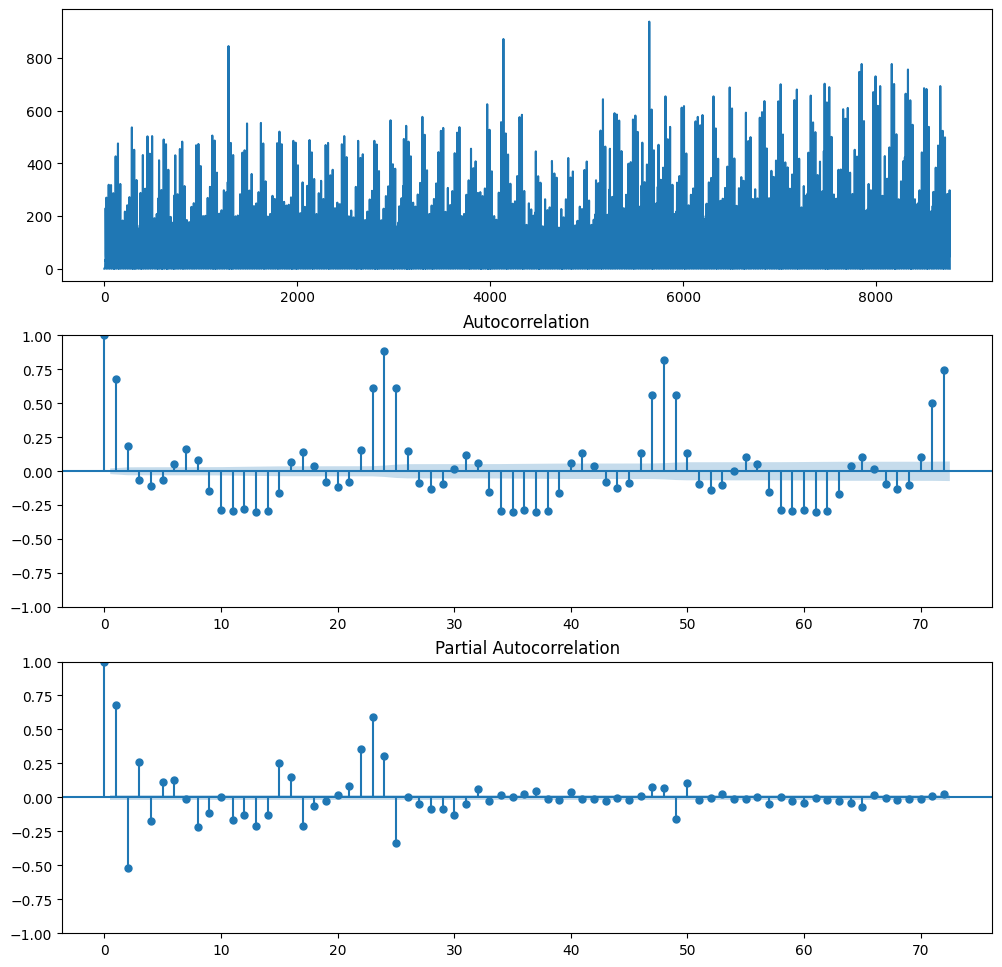

In [8]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(311)
ax1.plot(data.orders)

ax2 = fig.add_subplot(312)
sm.graphics.tsa.plot_acf(data.orders, lags=72, ax=ax2); #semicolon, otherwise displays plots twice

ax3 = fig.add_subplot(313)
sm.graphics.tsa.plot_pacf(data.orders, lags=72, ax=ax3); 

plt.show()

## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?

### With ARIMA Models

In [9]:
def log_ts(df:pd.DataFrame, ts_col:str) -> pd.DataFrame:
    # ensure nonzero
    df[ts_col] = df[ts_col] +1
    # log
    df['log_'+ts_col] = np.log(df[ts_col])
    return df

In [10]:
data = log_ts(data, 'orders')

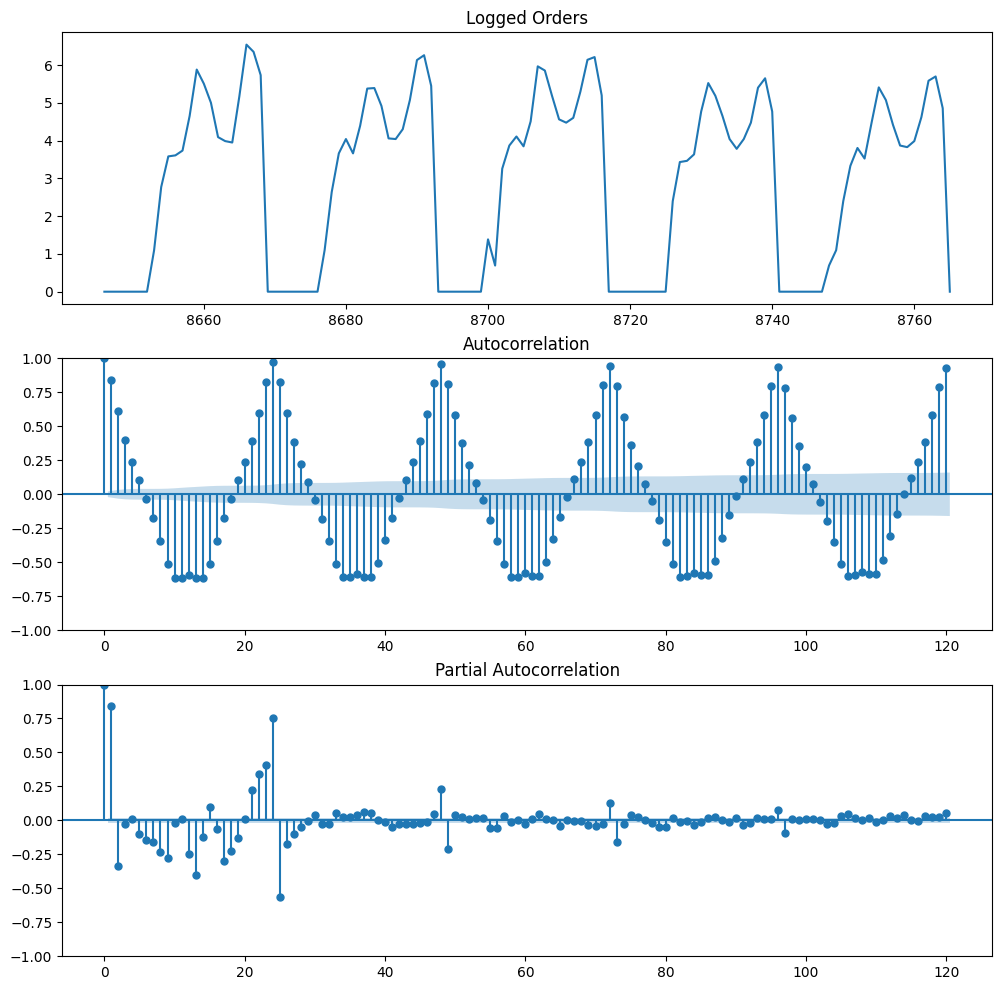

In [11]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(311)
ax1.set_title('Logged Orders')
ax1.plot(data['log_orders'][-120:])

ax2 = fig.add_subplot(312)
sm.graphics.tsa.plot_acf(data['log_orders'], lags=120, ax=ax2); #semicolon, otherwise displays plots twice

ax3 = fig.add_subplot(313)
sm.graphics.tsa.plot_pacf(data['log_orders'], lags=120, ax=ax3); 

plt.show()

In [33]:
from sktime.forecasting.arima import ARIMA

y = data['orders']

forecaster = ARIMA(  
    order=(24, 0, 24),
    seasonal_order=(0, 0, 0, 0),
    suppress_warnings=True)

forecaster.fit(y)  

y_pred = forecaster.predict(fh=range(1,24))  

In [34]:
y_pred

8766      6.819097
8767      7.297457
8768      8.064036
8769      3.293598
8770      2.910210
8771     10.592146
8772      0.184595
8773      5.370874
8774     10.787900
8775     29.204042
8776     42.547404
8777     29.119841
8778     89.304602
8779    216.551856
8780    169.165346
8781     79.205964
8782     48.553822
8783     46.150454
8784     50.418813
8785     99.922686
8786    251.714602
8787    292.059620
8788    121.833559
Name: orders, dtype: float64

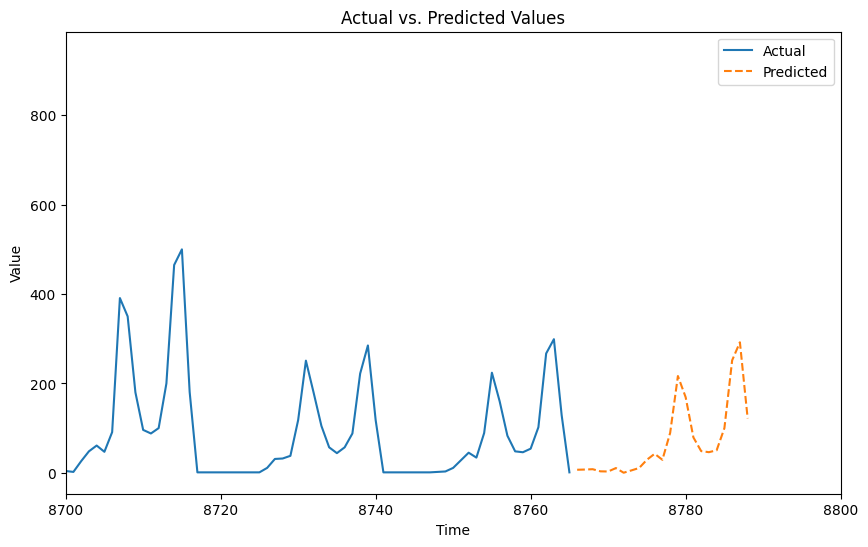

In [36]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.xlim(8700,8800)
plt.legend()
plt.show()

### With a NNet

In [68]:
array_of_values = data['log_orders']
array_of_dates = data['time']
fcst_horizon_length = 1

In [69]:
from scalecast.Forecaster import Forecaster

f = Forecaster(
    y = array_of_values,
    current_dates = array_of_dates,
    future_dates=fcst_horizon_length,
    test_length = 0.2, # do you want to test all models? if so, on how many or what percent of observations?
    cis = False, # evaluate conformal confidence intervals for all models?
    metrics = ['mae'], # what metrics to evaluate over the validation/test sets?
)

In [70]:
f.set_estimator('lstm')

In [85]:
f.manual_forecast(
    lags= 2400,
    batch_size=64,
    epochs=4,
    validation_split=.2,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0001,
    lstm_layer_sizes=(64,)*4,
    dropout=(0,)*4,
)

Epoch 1/4
 4/36 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - loss: 0.3923

KeyboardInterrupt: 

(19024.0, 19026.0)

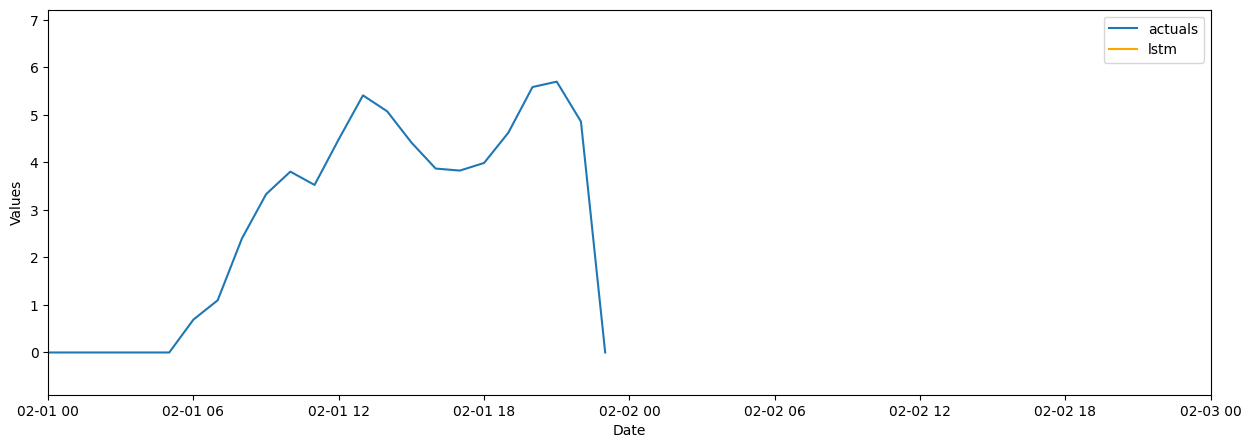

In [84]:
f.plot(models='lstm', figsize=(15,5))
plt.xlim(xmin=pd.to_datetime('2022-02-01'), xmax=pd.to_datetime('2022-02-03'))